# Project 2, Feed Forward Neural Network
## Setup

In [11]:
# NN imports

import seaborn as sns
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [12]:
## FFNN with backpropagation, sigmoid activation function
## Franke function data, compare to project 1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.random.seed(0)

# Functions
def R2(y_data, y_model): #score function
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model): #mean square error
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def FrankeFunction(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n): 
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

# Noisy Franke plot from Project 1
N = 40
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

x_, y_ = np.meshgrid(x,y)

var = 0.1 # Variance of noise 
noise = np.random.normal(0, var, len(x_)*len(x_)) 
noise = noise.reshape(len(x_), len(x_))

z = FrankeFunction(x_, y_) + noise #Franke with added noise

In [13]:
## Prepare data like for linear regression (?)
## Should the design matrix be prepared differently?

n = 5 # Regression polynomial degree (this affects the approximate terrain plot below)
X = create_X(x_, y_, n) # Construct design matrix

H = (2.0/(N)) * X.T @ X # Hessian matrix
EigVal, EigVec = np.linalg.eig(H)
print(f"The eigenvalues of Hessian matrix are: \n {EigVal}")

# We split the data in training (80%) and test (20%) data
X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z).reshape(-1,1), test_size=0.2)
print(np.shape(z_train))

The eigenvalues of Hessian matrix are: 
 [1.92527408e+02 3.23998329e+01 2.04418780e+01 3.01981079e+00
 1.77314580e+00 1.43094242e+00 2.10260232e-01 8.92168091e-02
 4.36910578e-02 4.67081004e-02 7.85156104e-03 2.23003796e-03
 1.30358063e-03 7.10770181e-04 6.12197961e-04 1.25096086e-04
 3.00631801e-05 1.26767951e-05 4.42837463e-06 6.23730775e-06
 8.52296922e-06]
(1280, 1)


The eigenvalues are all positive values, meaning the Hessian is positive definite. This also means that the cost function will not have any local minima that can disturb the gradient descent later. (?)

## Building feed forward neural network

In [14]:
# Building our neural network (borrowed, lect notes 14.2.4)
# Initialization

n_inputs, n_features = X_train.shape
n_hidden_neurons = 20 #start with few neurons
h = 1 #nr of hidden layers
n_categories = 1

def Initialize(var, bias):
    # weights scaled down because of small z values (max vals of scale of order 10^0)
    # multiplied with *1 means the gradient descent needs a lot of epochs to converge
    # weights and bias in the hidden layer
    hidden_weights = np.random.randn(n_features, n_hidden_neurons)*var
    hidden_bias = np.zeros(n_hidden_neurons) + bias

    # weights and bias in the output layer
    output_weights = np.random.randn(n_hidden_neurons, n_categories)*var
    output_bias = np.zeros(n_categories) + bias
    return hidden_weights, hidden_bias, output_weights, output_bias

In [15]:
## Feed-forward pass

# Sigmoid modified to prevent numerical errors for large x
def sigmoid(x):
    if x >= 0:
        return 1 / (1 + np.exp(-x))
    else:
        z = np.exp(x)
        return z/(1+z)
sigmoid = np.vectorize(sigmoid)

# a = 0.01 represents 'leaky relu'
# a = 0 represents standard RELU
def RELU(x, a = 0.01): #
    if x < 0:
        return a*(np.exp(x) - 1)
    else:
        return x
RELU = np.vectorize(RELU) 


# implement if statement for different activation
# activation inputs: 'sigmoid', 'relu', 'leaky relu', 'tanh'
def feed_forward(X, hidden_weights, output_weights, activation = 'Sigmoid'): # modified for regression
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) 
    # activation in the hidden layer 
    if activation == 'Sigmoid':
        a_h = sigmoid(z_h)
    elif activation == 'Leaky RELU':
        a_h = RELU(z_h)
    elif activation == 'RELU':
        a_h = RELU(z_h, a = 0)
    elif activation == 'Tanh':
        a_h = np.tanh(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights)
    return a_h, z_o

This is a poor first guess, but back propagation with gradient descent should approach a good fit given enough epochs. MSE as cost function.

## Implementing backward propagation

In [16]:
## Back propagation (also borrowed from lecture notes)
## Continue until cost function converges

def backpropagation(X, Y, activation, hidden_weights, output_weights):
    # Feed forward pass
    a_h, z_o_ = feed_forward(X, hidden_weights, output_weights, activation)
    
    # error in the output layer
    # scaled with amount of data to prevent numerical errors at large generated weights
    error_output = (z_o_ - Y)/Y.shape[0]
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient, z_o_

### Complete FFNN architecture with backpropagation
def FFNN(X, Y, activation, epochs = 300, eta = 0.5, lmbd = 0.01):
    # Initialize weights and biases
    hidden_weights, hidden_bias, output_weights, output_bias = Initialize(var = 0.01, bias = 0.01)
    MSE_NN = np.zeros(epochs) # save MSE every step
    
    # Network training
    for i in range(epochs):
        # calculate gradients
        dWo, dBo, dWh, dBh, z_o_ = backpropagation(X, Y, activation, hidden_weights, output_weights)

        # regularization term gradients
        dWo += lmbd * output_weights
        dWh += lmbd * hidden_weights

        # update weights and biases
        output_weights -= eta * dWo
        output_bias -= eta * dBo
        hidden_weights -= eta * dWh
        hidden_bias -= eta * dBh

        # save mse for each step
        MSE_NN[i] = MSE(Y, z_o_)
    
    # Plotting MSE for each epoch step
    epoch = np.linspace(0, epochs, epochs)
    plt.plot(epoch, MSE_NN, lw = 3, 
    label = f'{activation}, $\eta = {eta}$, $\lambda = {lmbd}$, '+'$MSE_{min}$ = '+f'{round(np.min(MSE_NN),3)}')
    return epoch, MSE_NN

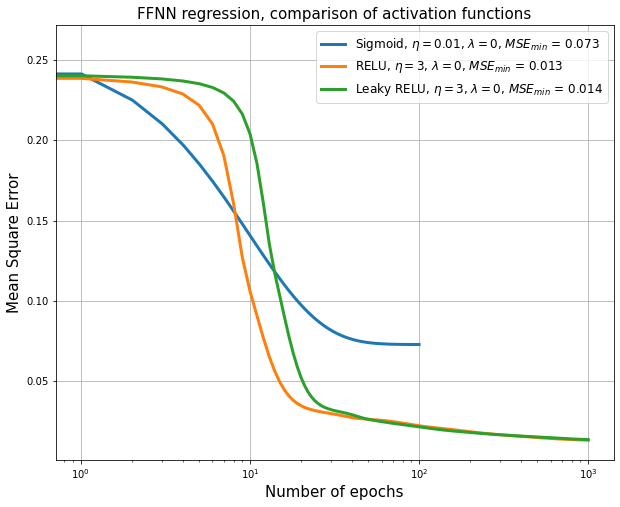

In [17]:
# Runs with different activation functions


## Plotting MSE for each epoch 
fig = plt.figure(figsize = (10, 8))
plt.title('FFNN regression, comparison of activation functions', fontsize = 15)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Mean Square Error', fontsize = 15)

#X, Y, activation function, epochs, learning rate, regularization constant
e1, m1 = FFNN(X_train, z_train, 'Sigmoid', 100, 0.01, 0)
e2, m2 = FFNN(X_train, z_train, 'RELU', 1000, 3, 0)
e3, m3 = FFNN(X_train, z_train, 'Leaky RELU', 1000, 3, 0)

#diverges suddenly
#e4, m4 = FFNN(X_train, z_train, 'Tanh', 160, 0.5, 0.01)

plt.xscale('log'); plt.grid(1)
plt.legend(prop={'size': 12})#; plt.savefig('FFNN1')
plt.show()

Appears to converge around MSE = 0.07 with sigmoid (0.02 with relu), which is worse performance than our OLS analysis in proj1. The sigmoid function performs decidedly worst, but converges really quickly. Using RELU we surpass the performance of our project 1 script after enough epochs.

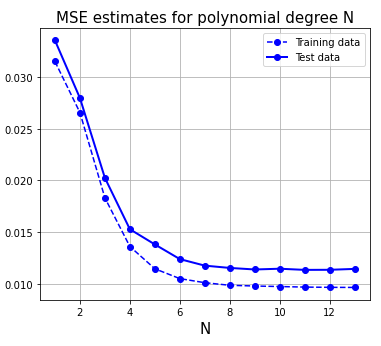
Above: results from ordinary least squares regression in project 1

## Parameter analysis

Let's evaluate the effect of change in parameters $\eta$ and $\lambda$, the chosen parameters for the RELU plots above are informed by the following analysis. A heatmap with axes $\eta$ and $\lambda$ would probably be more ideal to determine the relation between the parameters but we don't have time for that (it would also take a long time to run).

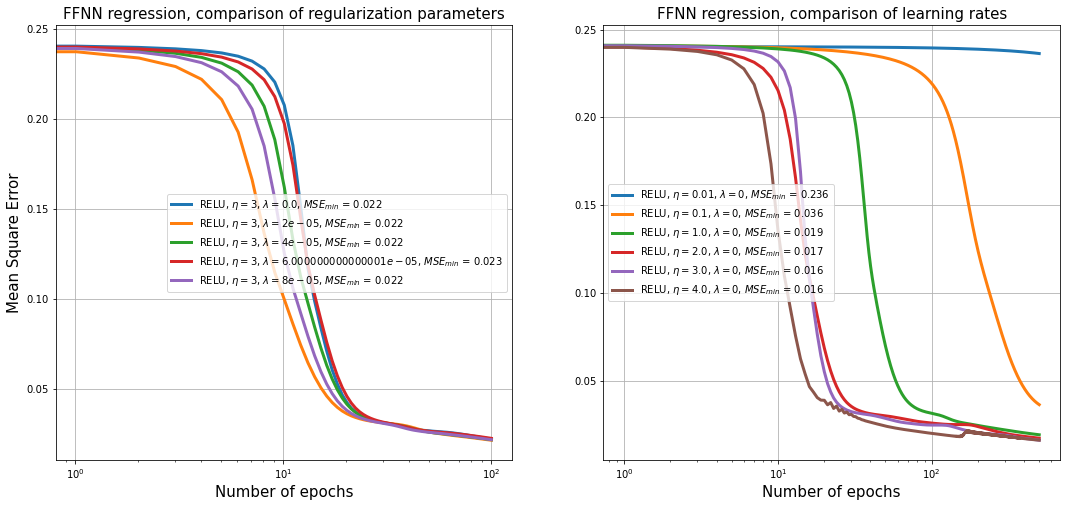

In [18]:
# Plot with constant eta, relu activation

fig = plt.figure(figsize = (18, 8))
plt.subplot(1, 2, 1)
plt.title('FFNN regression, comparison of regularization parameters', fontsize = 15)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Mean Square Error', fontsize = 15)

for i in range(5):
    # increase of factor i every iteration, incl i = 0
    lambd = 0.00002*i 
    FFNN(X_train, z_train, 'RELU', 100, 3, lambd)
    
plt.xscale('log'); plt.grid(1)
plt.legend(prop={'size': 10})

plt.subplot(1, 2, 2)
plt.title('FFNN regression, comparison of learning rates', fontsize = 15)
plt.xlabel('Number of epochs', fontsize = 15)
#plt.ylabel('Mean Square Error', fontsize = 15)

eta = np.array([0.01, 0.1, 1, 2, 3, 4])
for i in range(len(eta)):
 
    FFNN(X_train, z_train, 'RELU', 500, eta[i], 0)
    
plt.xscale('log'); plt.grid(1)
plt.legend(prop={'size': 10})#; plt.savefig('Parameters')
plt.show()


Conclusion from plots: regularization parameter seems to have low impact on final MSE (small differences after 100 epochs). As long as the learning rate is not too small, they seem to give similar final results. We'll choose $\eta = 3$ and $\lambda = 0$ for the network using RELU.

## Building the network with scikit-learn 

In [19]:
from sklearn.neural_network import MLPRegressor
# MLP = Multi-Layer Perceptron
# run this block to reset dnn object

import warnings
warnings.filterwarnings('ignore')

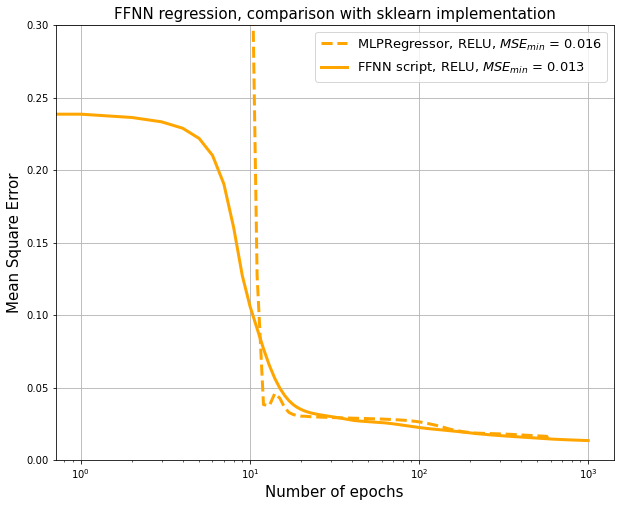

In [20]:
epochs = 1000
# activation; ‘identity’, ‘logistic’ (sigmoid), ‘tanh’, ‘relu’
dnn = MLPRegressor(hidden_layer_sizes=n_hidden_neurons, activation='relu', early_stopping = False, 
                    alpha=0, learning_rate_init=3, max_iter=epochs, verbose = False, shuffle = False,
                  tol = 0.000001, solver = 'adam', random_state = 0)

dnn.fit(X_train, z_train.ravel())
#print(f'Accuracy score on train set: {dnn.score(X_test, z_test)}')

# Compare with the result of our own script
#z_predict = dnn.predict(X_test)

loss = getattr(dnn, 'loss_curve_')
itr = getattr(dnn, 'n_iter_')

epoch = np.linspace(0, itr, itr)

# Comparing loss with our own code
fig = plt.figure(figsize = (10, 8))
plt.title('FFNN regression, comparison with sklearn implementation', fontsize = 15)
plt.xlabel('Number of epochs', fontsize = 15)
plt.ylabel('Mean Square Error', fontsize = 15)

plt.plot(epoch, loss, 'orange', lw = 3, ls = '--', 
         label = 'MLPRegressor, RELU, '+'$MSE_{min}$ = '+f'{round(np.min(loss),3)}')
plt.plot(e2, m2, 'orange', lw = 3, label = 'FFNN script, RELU, '+'$MSE_{min}$ = '+f'{round(np.min(m2),3)}')
plt.ylim(0, 0.3)
plt.xscale('log'); plt.grid(1)
plt.legend(prop={'size': 13})#; plt.savefig('FFNN2')
plt.show()

Except the fact that the initial weights and biases in the MLPRegressor method are a lot larger than the ones we generated for our code, the MSE plots seem to somewhat agree with eachother above 100 epochs.

Keep in mind though, random_state is set to 0, meaning that we get the same gradient descent each run. In this case the MLPRegressor gave us a nice curve with a similar minima to the FFNN function, but other states than 0 were more unstable. 

It is also worth mentioning that the 'adam' solver is used here, which is a slight deviation from the FFNN function, but attempting to use the solver 'sgd' resulted in nonsense results where the loss increased dramatically every step. This may be a consequence of setting up the method incorrectly.